In [43]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import ranges
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [ ]:
from MAE_parser import MAE_parser


def df_from_dir(dir_path):
    mae_parser = MAE_parser()
    xml_files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
    xml_files.sort()
    dfs_list = []
    for file_id, file_name in enumerate(xml_files):
        df = mae_parser.parse_file(join(dir_path, file_name))
        df['file_id'] = file_id
        dfs_list.append(df)
    return pd.concat(dfs_list, sort=False)


def clean_dfs(gold_df, app_df):
    unknown_columns = [gold_df_col for gold_df_col in gold_df.columns if gold_df_col not in app_df.columns]
    gold_df.drop(columns=unknown_columns, inplace=True)
    


gold_df = df_from_dir("./gold_anots")
app_df = df_from_dir("./app_anots")
# clean_dfs(gold_df, app_df)

    

In [2]:
# returns length of ranges within range set
def get_range_set_length(range_set):
    return sum((r.length() for r in range_set))

# creates range set of ranges based on tag spans in given data frame view
def get_ranges(view_df):
    range_set = ranges.RangeSet()
    for row in view_df.itertuples(index=False):
        range_set.update(ranges.Range(row.begin, row.end))
    return range_set

In [3]:
print(gold_df.head())

   id                                               text  begin  end  \
0  S0                                                 1.     47   48   
1  o0  Grupy stanowisk pracowników niebędących nauczy...     48  109   
2  a0                                            określa    109  116   
3  o1               regulamin organizacyjny Uniwersytetu    116  150   
4  S1                                                 2.    150  151   

    category RodzajAC  file_id @Voice @komentarz  
0  SEPARATOR      NaN        0    NaN        NaN  
1     oBject      NaN        0    NaN        NaN  
2        aIm      NaN        0    NaN        NaN  
3     oBject      NaN        0    NaN        NaN  
4  SEPARATOR      NaN        0    NaN        NaN  


In [4]:
# calculates coverage for given file and category
# correct_coverage_length is length of all spans that were annotated by the same category in given file
# wrong_coverage_length is length of all spans that application annotated by given category and GS annotated them with another category
# gs_coverage_length is length of all spans that gs annotated by given category
# app_coverage_length is length of all spans that application annotated by given category

def calculate_coverage(file_id, category, gold_df, app_df):
    app_ranges = get_ranges(app_df[(app_df['file_id'] == file_id) & (app_df['category'] == category)])
    gold_ranges = get_ranges(gold_df[(gold_df['file_id'] == file_id) & (gold_df['category'] == category)])
    correct_coverage = get_range_set_length(app_ranges.intersection(gold_ranges)) / get_range_set_length(gold_ranges)
    wrong_coverage = get_range_set_length(app_ranges.difference(app_ranges.intersection(gold_ranges))) / get_range_set_length(gold_ranges)
    return {'file_id': file_id, 
            'category': category, 
            'correct_coverage_length': get_range_set_length(app_ranges.intersection(gold_ranges)), 
            'wrong_coverage_length': get_range_set_length(app_ranges.difference(app_ranges.intersection(gold_ranges))),
            'gs_coverage_length': get_range_set_length(gold_ranges),
            'app_coverage_length': get_range_set_length(app_ranges),
           }

In [5]:
file_ids = app_df['file_id'].unique()
categories = app_df['category'].unique()

tag_coverage = []
for file_id in file_ids:
    for category in categories:
        tag_cov = calculate_coverage(file_id, category, gold_df, app_df)
        tag_coverage.append(tag_cov)
        


In [26]:
# applies percentage coverage calculation
def apply_percentage_calculations(df):
    df['precision'] = df.apply(lambda row: None if row.app_coverage_length == 0
                                                else round(row.correct_coverage_length * 100 / row.app_coverage_length, 2),
                               axis=1)
    df['recall'] = df.apply(lambda row: None if row.gs_coverage_length == 0
                                             else round(row.correct_coverage_length * 100 / row.gs_coverage_length, 2),
                            axis=1)
    print(df.head())
    df['F1'] = df.apply(lambda row: None if row.recall is None or row.precision is None
                                         else round((2 * row.precision * row.recall) / (row.precision + row.recall), 2),
                        axis=1)
    # df['F1'] = df.apply(lambda row: print(row.recall), axis=1)

    

In [27]:
coverage_df = pd.DataFrame(tag_coverage)
general_summary_df = coverage_df.groupby('category').sum().drop(columns=['file_id'])
apply_percentage_calculations(general_summary_df)

file_summary_df = coverage_df.groupby(['file_id', 'category']).sum()
apply_percentage_calculations(file_summary_df)


           correct_coverage_length  wrong_coverage_length  gs_coverage_length  \
category                                                                        
Attribute                     7322                  22261               11711   
Deontic                        411                      9                 717   
SEPARATOR                        0                     58                 566   
aCtor                         1049                    643               12972   
aIm                           3694                   1171                6336   

           app_coverage_length  precision  recall  
category                                           
Attribute                29583      24.75   62.52  
Deontic                    420      97.86   57.32  
SEPARATOR                   58       0.00    0.00  
aCtor                     1692      62.00    8.09  
aIm                       4865      75.93   58.30  
                   correct_coverage_length  wrong_coverage_length  \

/home/michal/PW/PADT/IG_metrices/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [36]:
general_summary_df.to_csv('general_summary.csv')
file_summary_df.to_csv('file_summary.csv')

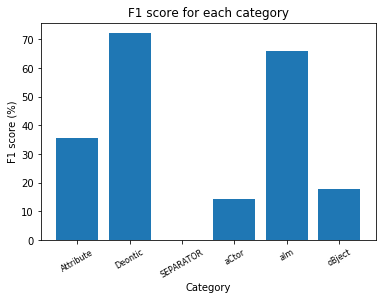

<Figure size 1280x960 with 0 Axes>

In [58]:
def plot_bar():
    # this is for plotting purpose
    index = np.arange(len(general_summary_df.index))
    plt.bar(index, general_summary_df['F1'])
    plt.xlabel('Category', fontsize=10)
    plt.ylabel('F1 score (%)', fontsize=10)
    plt.xticks(index, general_summary_df.index, fontsize=8, rotation=30)
    plt.title('F1 score for each category')
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.show()

plot_bar()

In [ ]:
# MAIN ISSUE:

# ig_annotator annotates preprocessed text that differs from original
# this tags refer to the same part of text
# APP annotation: <aCtor id="aC7" spans="16265~16344" text="6 Ogólnouniwersytecką jednostkę organizacyjną, o której mowa w ust 1 pkt 2 i 4," />
# GS annotation: <aCtor id="aC49" spans="16621~16700" text="Ogólnouniwersytecką jednostkę organizacyjną, o której mowa w ust. 1  pkt 2 i 4,"  />

# It's visible that this annotation of tag should get high score rating because application added just 2 characters too much on the beggining. However it gets zero score in current metric.
# Current metric is based on span coverage. Application get scoring based on spans that annotated the same in GS fle and APP file. 
# There was also idea to do metric based on text similiarity but without knowledge about location of given text in file (without spans) 
# there could be (and there are) multiple tags that annotates the same words but in different contexts, eg: deontics.

# Main goal of this metric (based on span coverage) was that if application annotation differs by few characters on end or start it will achieve high score anyway.
# However due to spans being missplaced (ig-annotator introduced new lines) and GS (created in MAE has double ) this metric kinda sucks.
# Anyway I think it will be near to impossible to create sensable metric based on two files whose baseline (same spans represent another texts) in skewed.